In [76]:
import sys
import pickle 
sys.path.append("../tools/")
import matplotlib 
matplotlib.use('TkAgg') 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from numpy import nan
import math
from scipy.stats import mode
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# pd.set_option('display.max_columns', None)

In [77]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
# features_list = ['poi', 'deferral_payments']
# features_list = ['poi', 'total_payments']
"""
features_list = ['poi','bonus', 'total_payments', 'from_poi_to_this_person']
Accuracy: 0.78564	Precision: 0.08257	Recall: 0.04950	F1: 0.06189	F2: 0.05381
	Total predictions: 14000	True positives:   99	False positives: 1100	False negatives: 1901	True negatives: 10900
---
features_list = ['poi', 'total_payments']
Accuracy: 0.76308	Precision: 0.06938	Recall: 0.04350	F1: 0.05347	F2: 0.04701
	Total predictions: 13000	True positives:   87	False positives: 1167	False negatives: 1913	True negatives: 9833
---
features_list = ['poi','bonus', 'total_payments']
Accuracy: 0.73877	Precision: 0.10205	Recall: 0.08950	F1: 0.09536	F2: 0.09176
	Total predictions: 13000	True positives:  179	False positives: 1575	False negatives: 1821	True negatives: 9425
---

"""
# features_list = ['poi', 'bonus']
# features_list = ['poi', 'restricted_stock_deferred']


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame(data_dict.values())
df = df.drop(['email_address'], axis=1)

print len(df)
poi = df[df.poi]
print len(poi)

146
18


In [78]:
#Create a new function:
def num_missing(x): 
    return sum(x == 'NaN')

def replace_nan(x):
    for index, val in enumerate(x):
         if x[index] == 'NaN':
            x[index] = 0
    return x

#Applying per column:
print "Missing values per column:"
print df.apply(num_missing, axis=0) #axis=0 defines that function is to be applied on each column

#Applying per row:
print "\nMissing values per row:"
print df.apply(num_missing, axis=1).head() #axis=1 defines that function is to be applied on each row

# df['bonus'].fillna(0)
df = df.apply(replace_nan, axis=1)


#Applying per column:
print "Missing values per column:"
print df.apply(num_missing, axis=0) #axis=0 defines that function is to be applied on each column

#Applying per row:
print "\nMissing values per row:"
print df.apply(num_missing, axis=1).head() #axis=1 defines that function is to be applied on each row

df

Missing values per column:
bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

Missing values per row:
0     7
1     8
2    10
3    11
4     4
dtype: int64
Missing values per column:
bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
from_mess

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,600000,0,0,0,0,94299,29,38,1,0,0,1740,False,585062,0,365788,702,807,1061827,585062
1,1200000,1295738,-1386055,0,6680544,11200,0,0,0,0,1586055,2660303,False,3942714,0,267102,0,0,5634343,10623258
2,350000,0,-400729,0,4890344,78552,0,0,0,0,0,12961,False,1788391,0,170941,0,0,211725,6678735
3,0,0,0,0,651850,0,12,10,0,0,0,0,False,386335,0,0,58,764,0,1038185
4,1500000,0,-3117011,0,5538001,34039,32,32,21,0,1617011,11350,True,853064,0,243293,1035,1045,288682,6391065
5,325000,0,0,0,0,35018,0,0,0,0,0,1411,False,208510,0,267093,0,0,628522,208510
6,0,1848227,0,0,493489,0,28,0,0,0,0,0,False,462384,0,0,22,232,1848227,955873
7,2600000,0,0,0,1104054,137108,48,58,26,0,694862,297353,False,558801,0,370448,2228,2355,4099771,1662855
8,0,3131860,0,0,5210569,0,1073,44,15,0,0,0,False,2046079,0,0,1074,2350,3131860,7256648
9,400000,1130036,-33333,0,880290,43057,222,61,48,0,0,778,False,409554,-409554,197091,742,1238,1737629,880290


In [85]:
### Task 2: Remove outliers

df['poi_val'] = (df['poi']).astype(int)
# df = df.drop(['email_address'], axis=1)
# df.fillna(0) 
# df['bonus'].fillna(0, inplace=True)

"""  
loan_advances 0.137684710097 
other 0.511266109219 
restricted_stock 0.626755789848
restricted_stock_deferred 0.393488787462  

""" 
curr_df_len = len(df)
# salary
df = df[np.abs(df.salary-df.salary.mean())<=(4*df.salary.std())]
print 'salary outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# bonus
df = df[np.abs(df.bonus-df.bonus.mean())<=(4*df.bonus.std())]
print 'bonus outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# total_payments
df = df[np.abs(df.total_payments-df.total_payments.mean())<=(4*df.total_payments.std())]
print 'total_payments outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# deferral_payments
df = df[np.abs(df.deferral_payments-df.deferral_payments.mean())<=(4*df.deferral_payments.std())]
print 'deferral_payments outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# deferred_income
df = df[np.abs(df.deferred_income-df.deferred_income.mean())<=(4*df.deferred_income.std())]
print 'deferred_income outliers: ', (curr_df_len - len(df))
curr_df_len = len(df) 
# director_fees
df = df[np.abs(df.director_fees-df.director_fees.mean())<=(4*df.director_fees.std())]
print 'director_fees outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# exercised_stock_options
df = df[np.abs(df.exercised_stock_options-df.exercised_stock_options.mean())<=(4*df.exercised_stock_options.std())]
print 'exercised_stock_options outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# expenses
df = df[np.abs(df.expenses-df.expenses.mean())<=(4*df.expenses.std())]
print 'expenses outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# from_messages
df = df[np.abs(df.from_messages-df.from_messages.mean())<=(4*df.from_messages.std())]
print 'from_messages outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# from_poi_to_this_person
df = df[np.abs(df.from_poi_to_this_person-df.from_poi_to_this_person.mean())<=(4*df.from_poi_to_this_person.std())]
print 'from_poi_to_this_person outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# from_this_person_to_poi
df = df[np.abs(df.from_this_person_to_poi-df.from_this_person_to_poi.mean())<=(4*df.from_this_person_to_poi.std())]
print 'from_this_person_to_poi outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# long_term_incentive
df = df[np.abs(df.long_term_incentive-df.long_term_incentive.mean())<=(4*df.long_term_incentive.std())]
print 'long_term_incentive outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# shared_receipt_with_poi
df = df[np.abs(df.shared_receipt_with_poi-df.shared_receipt_with_poi.mean())<=(4*df.shared_receipt_with_poi.std())]
print 'shared_receipt_with_poi outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# to_messages
df = df[np.abs(df.to_messages-df.to_messages.mean())<=(4*df.to_messages.std())]
print 'to_messages outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
# total_stock_value
df = df[np.abs(df.total_stock_value-df.total_stock_value.mean())<=(4*df.total_stock_value.std())]
print 'total_stock_value outliers: ', (curr_df_len - len(df))
curr_df_len = len(df)
df = df.sort_values(by=['bonus', 'total_payments'], ascending=[False, False])


cols_to_norm = ['bonus'                        ,
                'deferral_payments'            ,
                'deferred_income'              ,
                'director_fees'                ,
                'exercised_stock_options'      ,
                'expenses'                     ,
                'from_messages'                ,
                'from_poi_to_this_person'      ,
                'from_this_person_to_poi'      ,
                'loan_advances'                ,
                'long_term_incentive'          ,
                'other'                        ,
                'poi'                          ,
                'restricted_stock'             ,
                'restricted_stock_deferred'    ,
                'salary'                       ,
                'shared_receipt_with_poi'      ,
                'to_messages'                  ,
                'total_payments'               ,
                'total_stock_value']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
# df
# df = df.dropna(subset=['salary']) 
# df = df.drop(['deferral_payments','deferred_income', 'director_fees', 'restricted_stock_deferred', 'loan_advances'], axis=1) 
df

salary outliers:  0
bonus outliers:  1
total_payments outliers:  1
deferral_payments outliers:  2
deferred_income outliers:  2
director_fees outliers:  0
exercised_stock_options outliers:  2
expenses outliers:  0
from_messages outliers:  2
from_poi_to_this_person outliers:  1
from_this_person_to_poi outliers:  1
long_term_incentive outliers:  2
shared_receipt_with_poi outliers:  0
to_messages outliers:  0
total_stock_value outliers:  0


,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,poi_val
134,0.876534,-0.056056,0.066642,-0.095267,0.011595,0.532338,0.035833,0.111820,0.651906,-0.009434,...,0.146008,-0.075472,0.264011,0.041227,0.262607,0.454197,0.372326,0.668203,0.135833,0
36,0.556534,-0.056056,0.066642,-0.095267,-0.113622,0.554988,-0.009407,0.102016,-0.082788,-0.009434,...,-0.069708,-0.075472,0.003793,0.041227,0.120935,0.190724,0.235834,0.300406,-0.102534,0
52,0.476534,-0.056056,0.066642,-0.095267,0.130825,-0.210441,0.051856,0.043193,0.366192,-0.009434,...,0.929247,-0.075472,0.237000,0.041227,0.452202,0.640948,0.821652,0.820219,0.236229,0
76,0.416534,-0.056056,0.065567,-0.095267,-0.113622,0.299904,-0.009407,0.592212,0.202926,-0.009434,...,-0.069878,0.924528,-0.047931,0.041227,0.222934,0.450080,0.404645,0.435986,-0.126360,0
87,0.376534,-0.056056,-0.271963,-0.095267,-0.113622,0.066913,0.100866,0.881428,0.407008,-0.009434,...,-0.070491,0.924528,-0.082414,0.041227,0.164293,0.672759,0.636838,0.198339,-0.142243,0
42,0.276534,-0.056056,0.066642,-0.095267,-0.113622,-0.210441,0.024523,0.234369,0.182518,-0.009434,...,-0.069089,-0.075472,-0.018251,0.041227,0.215522,0.853897,0.707124,0.434750,-0.112688,0
29,0.276534,-0.056056,0.066642,-0.095267,0.081574,0.088137,0.002845,0.018683,0.060069,-0.009434,...,0.159077,-0.075472,-0.013448,0.041227,0.123740,0.353897,0.325888,0.292517,0.074255,0
142,0.276534,-0.056056,-0.236490,-0.095267,-0.113622,0.027081,0.011328,0.190252,0.141702,-0.009434,...,0.095480,0.924528,0.567699,0.041227,0.431454,0.447086,0.415313,0.251267,0.157216,0
12,0.216534,-0.056056,0.066642,-0.095267,-0.011703,0.441616,-0.021660,0.028487,-0.062380,-0.009434,...,-0.070606,-0.075472,-0.065172,0.041227,0.177051,0.724406,0.598244,0.284961,-0.037847,0
21,0.216534,-0.056056,0.066642,-0.095267,0.465220,0.183978,0.102751,-0.010729,-0.103196,-0.009434,...,-0.070752,-0.075472,0.307874,0.041227,0.342759,-0.065639,0.032194,0.235126,0.585343,0


In [80]:
### Task 3: Create new feature(s)

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
# data = featureFormat(my_dataset, features_list, sort_keys = True)
# labels, features = targetFeatureSplit(data)

"""

### Plot POI Vs Salary
plt.scatter(df.poi, df.salary)
plt.xlabel("Poi")
plt.ylabel("Salary")
plt.title("Poi vs Salary")
plt.show()
### Plot POI Vs Bonus
plt.scatter(df.poi, df.bonus)
plt.xlabel("Poi")
plt.ylabel("Bonus")
plt.title("Poi vs Bonus")
plt.show()
### Plot POI Vs total_payments
plt.scatter(df.poi, df.total_payments)
plt.xlabel("Poi")
plt.ylabel("total_payments")
plt.title("Poi vs total_payments")
plt.show()

### Plot POI Vs exercised_stock_options
plt.scatter(df.poi, df.exercised_stock_options)
plt.xlabel("Poi")
plt.ylabel("exercised_stock_options")
plt.title("Poi vs exercised_stock_options")
plt.show()


### Plot POI / Not POI
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.poi.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(df.poi.value_counts())) 
plt.title("POI (True = POI, False = Not POI)")

"""

'\n\n### Plot POI Vs Salary\nplt.scatter(df.poi, df.salary)\nplt.xlabel("Poi")\nplt.ylabel("Salary")\nplt.title("Poi vs Salary")\nplt.show()\n### Plot POI Vs Bonus\nplt.scatter(df.poi, df.bonus)\nplt.xlabel("Poi")\nplt.ylabel("Bonus")\nplt.title("Poi vs Bonus")\nplt.show()\n### Plot POI Vs total_payments\nplt.scatter(df.poi, df.total_payments)\nplt.xlabel("Poi")\nplt.ylabel("total_payments")\nplt.title("Poi vs total_payments")\nplt.show()\n\n### Plot POI Vs exercised_stock_options\nplt.scatter(df.poi, df.exercised_stock_options)\nplt.xlabel("Poi")\nplt.ylabel("exercised_stock_options")\nplt.title("Poi vs exercised_stock_options")\nplt.show()\n\n\n### Plot POI / Not POI\nplt.figure(figsize=(6,4))\nfig, ax = plt.subplots()\ndf.poi.value_counts().plot(kind=\'barh\', color="blue", alpha=.65)\nax.set_ylim(-1, len(df.poi.value_counts())) \nplt.title("POI (True = POI, False = Not POI)")\n\n'

bonus 2.36717867617
deferral_payments 0.478319644603
deferred_income 0.658736196015
director_fees 0.59833281349
exercised_stock_options 0.0323591820114
expenses 2.43931147411
from_messages 0.252704634824
from_poi_to_this_person 3.39516094505
from_this_person_to_poi 0.346716761718
loan_advances 0.123664545367
long_term_incentive 0.85598588899
other 0.991326752941
poi nan
restricted_stock 2.63838497261
restricted_stock_deferred 0.338535975586
salary 2.77104565027
shared_receipt_with_poi 2.10384025652
to_messages 1.11932786572
total_payments 1.75926347674
total_stock_value 0.572911397787


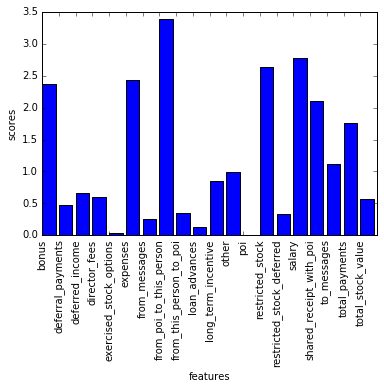

In [81]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
 
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ['bonus'                        ,
'deferral_payments'            ,
'deferred_income'              ,
'director_fees'                ,
'exercised_stock_options'      ,
'expenses'                     ,
'from_messages'                ,
'from_poi_to_this_person'      ,
'from_this_person_to_poi'      ,
'loan_advances'                ,
'long_term_incentive'          ,
'other'                        ,
'poi'                          ,
'restricted_stock'             ,
'restricted_stock_deferred'    ,
'salary'                       ,
'shared_receipt_with_poi'      ,
'to_messages'                  ,
'total_payments'               ,
'total_stock_value']
# , 'total_payments', 'bonus', 'exercised_stock_options', 'from_poi_to_this_person'
# Perform feature selection
selector = SelectKBest(f_classif, k='all')
selector.fit(df[predictors], df['poi_val'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

for i, sc in enumerate(scores):
    print predictors[i], scores[i]

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.ylabel('scores')
plt.xlabel('features')
plt.show()

In [82]:
# Applying Algorithms

### Selected features
all_features = ['bonus'                        ,
                'deferral_payments'            ,
                'deferred_income'              ,
                'director_fees'                ,
                'exercised_stock_options'      ,
                'expenses'                     ,
                'from_messages'                ,
                'from_poi_to_this_person'      ,
                'from_this_person_to_poi'      ,
                'loan_advances'                ,
                'long_term_incentive'          ,
                'other'                        ,
                'poi'                          ,
                'restricted_stock'             ,
                'restricted_stock_deferred'    ,
                'salary'                       ,
                'shared_receipt_with_poi'      ,
                'to_messages'                  ,
                'total_payments'               ,
                'total_stock_value']
selected_features = ['from_poi_to_this_person', 'bonus', 'restricted_stock']
selected_label = ['poi_val']

# GaussianNB()
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(df[selected_features], df[selected_label])


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [83]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)



In [84]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
